<a href="https://colab.research.google.com/github/sleepless-se/30nichideosjisaku/blob/master/page_satus_conv1d_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get -q -y install swig 
!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 10 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,194 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 

In [2]:
import sys, pickle, os, json, keras, time, re
from sklearn.model_selection import KFold
from keras.datasets import boston_housing
from keras.models import Model,model_from_json
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.datasets import mnist
from keras import models
from keras import layers
import numpy as np
from google.colab import files
from keras.metrics import categorical_accuracy
from scipy.stats import zscore
import random
import pandas as pd
import matplotlib.pyplot as plt
import MeCab
mecab = MeCab.Tagger("-Owakati")

Using TensorFlow backend.


In [0]:
def save_text_tokenizer(tokenizer,file_name):
  # saving
  with open(file_name+".pickle", 'wb') as handle:
      pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_text_tokenizer(file_name):
  # loading
  with open(file_name+".pickle", 'rb') as handle:
      return pickle.load(handle)

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
base_dir = "/content/gdrive/My Drive/data/status_filter/"
!ls "/content/gdrive/My Drive/data/status_filter/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
data	   error_domain.csv  text_token.pickle
error.csv  page_st.csv	     weights.best.h5


In [5]:
page_file_name = 'page_st.csv'
target_columns = ['label','text']
dtype ={'label':str,'text':str} 
raw_df = pd.read_csv(base_dir + page_file_name,sep=',',error_bad_lines=False, dtype=dtype,engine='python')
# raw_df2 = pd.read_csv(base_dir + 'new_status.csv',sep=',',error_bad_lines=False, dtype=dtype,engine='python')
# raw_df = pd.concat([raw_df,raw_df2],axis=0)
raw_df = raw_df[~raw_df.duplicated()]
print('raw_df',raw_df.shape)
print(raw_df.columns)
print(raw_df['label'].value_counts())
raw_df.to_csv(base_dir+'page_st.csv',index=False)

raw_df (2452, 3)
Index(['label', 'url', 'text'], dtype='object')
no        1463
stock      692
list       139
top         96
login       25
block       25
except      12
Name: label, dtype: int64


In [0]:
def change_label(label):
  if label != 'stock' :label = 'no'
  return label

raw_df['label'] = raw_df['label'].apply(lambda x : change_label(x))

In [7]:
raw_df = raw_df.dropna()
raw_df = raw_df.sample(frac=1)
print(raw_df["label"].value_counts())
print('raw_df',raw_df.shape)
print(raw_df.columns)


no       1760
stock     692
Name: label, dtype: int64
raw_df (2452, 3)
Index(['label', 'url', 'text'], dtype='object')


In [9]:
text = 'sorry we can t this product page 　　re sold out 404 whoops our bad it gone out of stock 切れ 在庫 なし 完売 ました 売り 切れ ページ 見つかり ません この 製品 もう 入手 できません'
def prepro(text:str)->list:
  line = ""
  text = mecab.parse(str(text)).replace("↵"," ")
  text = re.sub('{.*}','',text)
  words = text.lower()
  return words
prepro(text)


'sorry we can t this product page \u3000 \u3000 re sold out 404 whoops our bad it gone out of stock 切れ 在庫 なし 完売 まし た 売り 切れ ページ 見つかり ませ ん この 製品 もう 入手 でき ませ ん \n'

In [0]:
raw_df['edit_text'] = raw_df['text'].apply(lambda x : prepro(x))
token = keras.preprocessing.text.Tokenizer(num_words=250)
token.fit_on_texts(raw_df['edit_text'].values)


In [206]:
raw_df['edit_text'] = raw_df['text'].apply(lambda x : prepro(x))
regex = "^(sorry.? (we can.t|this (product|page)))|^(sorry we.re sold out)|^(404|whoops, our bad...|it.s gone|out of stock|sold out|在庫切れ|在庫なし|完売しました|売り切れ|ページが見つかりません.*|この製品はもう入手できない.|ci scusiamo per l'inconveniente.|sorry!|back to our favs)$|(((product|page|item|requested) (is |was )?)(not found|no longer|sold out|out of stock|not available))|(re (sorry|sold out)|(ご購入いただけません)|(404 error))|^(sold out\\s*){3,}|ARTICLE.*EN LIGNE|^so sorry.*|404 page not|Don.t Cry|.*is out of stock.|articolo non disponibile";
p = re.compile(regex)
raw_df['flag'] = raw_df['text'].apply(lambda x : 0 if p.match(x) == None else 1)
raw_df['edit_text'] = raw_df['edit_text'].fillna("")

token = keras.preprocessing.text.Tokenizer(num_words=250)
token.fit_on_texts(raw_df['edit_text'].values)
save_text_tokenizer(token,base_dir + 'text_token')
X = token.texts_to_matrix(raw_df['edit_text'].values)
flag = np.array(raw_df['flag'])
flag = flag.reshape(len(flag),1)
print('flag',flag.shape,'X',X.shape)
# X = np.concatenate((flag,X),axis=1)

# X = flag
# text_len = len(X[0])
# print(f'text_len:{text_len} samples:{len(X)}')
print('word_count',len(token.word_counts))
print(token.word_counts)
print(token.word_index)
X = np.array(X)
print('X',X.shape)

X_seq = token.texts_to_sequences(raw_df['text'].values)
X_seq = sequence.pad_sequences(X_seq)
max_len = X_seq.shape[1]
# X_seq = X_seq.reshape(X_seq.shape[0],1,X_seq.shape[1])
print('X_seq',X_seq.shape)

flag (2452, 1) X (2452, 250)
word_count 27734
OrderedDict([('free', 1968), ('shipping', 2715), ('to', 8434), ('the', 8777), ('usa', 105), ('australia', 299), ('canada', 285), ('and', 7478), ('new', 2791), ('zealand', 177), ('usd', 805), ('gbp', 293), ('cad', 108), ('aud', 259), ('eur', 223), ('nzd', 31), ('chf', 45), ('ils', 10), ('jpy', 950), ('sgd', 35), ('sign', 1704), ('in', 4744), ('0', 2642), ('shop', 1703), ('best', 430), ('sellers', 71), ('arrivals', 546), ('sale', 1272), ('wedding', 98), ('rings', 82), ('blog', 246), ('stock', 463), ('pieces', 612), ('collections', 302), ('cuffs', 64), ('feature', 22), ('cuff', 139), ('mens', 388), ('silver', 354), ('bracelet', 275), ('rustic', 26), ('man', 356), ('79', 166), ('size', 2304), ('small', 193), ('medium', 111), ('large', 104), ('engraved', 76), ('custom', 218), ('stamp', 53), ('no', 727), ('1', 2725), ('10', 1804), ('characters', 160), ('11', 542), ('20', 1020), ('21', 283), ('30', 1124), ('31', 217), ('40', 756), ('41', 204), ('5

In [0]:
index2word =  {i+1:key for i, key in enumerate(token.word_index)}
# index2word

In [0]:
# label_token = keras.preprocessing.text.Tokenizer()
# label_token.fit_on_texts(raw_df['label'].values)
# y = label_token.texts_to_matrix(raw_df['label'].values)
# label_len = len(label_token.word_counts) + 1
raw_df['true'] = raw_df['label'].apply(lambda x : 1 if x == 'stock' else 0)
y = to_categorical(raw_df['true'].values)
# print('word_index',label_token.word_index)
# print('label_len',label_len)
# print('y shape',y.shape)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.33, random_state=42)

In [278]:

def get_model(param):
  embedding_size = 1500
  
#   input_matrix = layers.Input(shape=(250,))
  input_seq = layers.Input(shape=(max_len,))
  
  embedding_layer = layers.Embedding(embedding_size,output_dim=64)

#   first_input_encoded = embedding_layer(input_matrix)
  second_input_encoded = embedding_layer(input_seq)
  
#   dense_layer = layers.Dense(512)(first_input_encoded)
  conv_layer = layers.Conv1D(64,9,activation='relu')(second_input_encoded)
  conv_layer = layers.Conv1D(64,9,activation='relu')(conv_layer)
  conv_layer = layers.MaxPooling1D(9)(conv_layer)
  conv_layer = layers.Dropout(0.25)(conv_layer)
  conv_layer = layers.Conv1D(128, 6, activation='relu')(conv_layer)
#   rnn_layer = layers.Bidirectional(layers.LSTM(2, return_sequences=True,dropout=0.4, kernel_initializer='Orthogonal'))(conv_layer) 
  rnn_layer = layers.Bidirectional(layers.CuDNNLSTM(8, return_sequences=True, kernel_initializer='Orthogonal'))(conv_layer) 
  rnn_layer = layers.Bidirectional(layers.CuDNNLSTM(2, return_sequences=True, kernel_initializer='Orthogonal'))(rnn_layer) 

  rnn_layer = layers.Flatten()(rnn_layer)
#   conv_layer = layers.SimpleRNN(2,recurrent_dropout=0.3)(conv_layer)
#   conv_layer = layers.Dense(8,activation='relu')(conv_layer)
  output = layers.Dense(2,activation='softmax')(rnn_layer)
  
#   model = Model(inputs=[input_matrix, input_seq], outputs=output)
  model = Model(inputs=input_seq, outputs=output)
  model.compile(loss='categorical_crossentropy',optimizer ='adam',metrics=['categorical_accuracy'])
  return model

get_model(0.2).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_204 (InputLayer)       (None, 899)               0         
_________________________________________________________________
embedding_155 (Embedding)    (None, 899, 64)           96000     
_________________________________________________________________
conv1d_218 (Conv1D)          (None, 891, 64)           36928     
_________________________________________________________________
conv1d_219 (Conv1D)          (None, 883, 64)           36928     
_________________________________________________________________
max_pooling1d_79 (MaxPooling (None, 98, 64)            0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 98, 64)            0         
_________________________________________________________________
conv1d_220 (Conv1D)          (None, 93, 128)           49280     
__________

Train on 1313 samples, validate on 329 samples
Epoch 1/150
1313/1313 [==============================] - 33s 25ms/step - loss: 0.6757 - categorical_accuracy: 0.5476 - val_loss: 0.6130 - val_categorical_accuracy: 0.7234
Epoch 2/150
1313/1313 [==============================] - 1s 654us/step - loss: 0.6006 - categorical_accuracy: 0.7251 - val_loss: 0.6039 - val_categorical_accuracy: 0.7234
Epoch 3/150
1313/1313 [==============================] - 1s 539us/step - loss: 0.5995 - categorical_accuracy: 0.7251 - val_loss: 0.5898 - val_categorical_accuracy: 0.7234
Epoch 4/150
1313/1313 [==============================] - 1s 543us/step - loss: 0.5879 - categorical_accuracy: 0.7251 - val_loss: 0.5929 - val_categorical_accuracy: 0.7234
Epoch 5/150
1313/1313 [==============================] - 1s 535us/step - loss: 0.5920 - categorical_accuracy: 0.7251 - val_loss: 0.5918 - val_categorical_accuracy: 0.7234
Epoch 6/150
1313/1313 [==============================] - 1s 547us/step - loss: 0.5896 - categorica

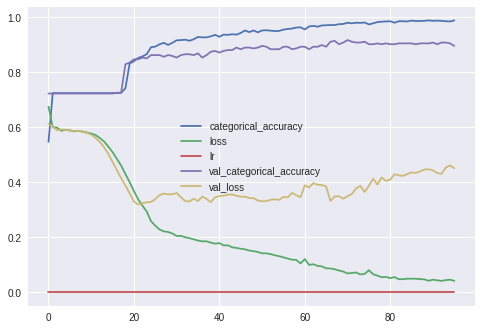

In [279]:
from tensorflow.python.keras.callbacks import TensorBoard

EPOCHS = 150
BATCH_SIZE = 512

# stop when score is not improve
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=25)

# save best score
filepath = base_dir+"weights.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')


# TensorBoard
tsb = TensorBoard(log_dir=base_dir+'logs')

# reduce 
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.01)
callbacks_list = [checkpoint,early_stopping,reduce,tsb]

train_data = X_seq[:2000]

model = get_model(0.4)
history = model.fit(X_train, y_train, validation_split=0.2,verbose=1,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=callbacks_list)
score = model.evaluate(X_train, y_train)
print(score)
history = pd.DataFrame(history.history)
history.plot()
# scores = []
# historys = []
# kf = KFold(n_splits=4, random_state=None, shuffle=False)
# for train_index, test_index in kf.split(X):
#   model = get_model()
#   train_data = [X[train_index], X_seq[train_index]]
#   test_data = [X[test_index], X_seq[test_index]]
#   history = model.fit(train_data, y[train_index], validation_split=0.2,verbose=0,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=callbacks_list)
#   historys.append(history)
#   score = model.evaluate(test_data,y[test_index])
#   print(score)
#   scores.append(score)


Train on 1961 samples, validate on 491 samples
Epoch 1/150
1961/1961 [==============================] - 33s 17ms/step - loss: 0.6665 - categorical_accuracy: 0.6512 - val_loss: 0.6041 - val_categorical_accuracy: 0.7128
Epoch 2/150
1961/1961 [==============================] - 3s 2ms/step - loss: 0.5985 - categorical_accuracy: 0.7190 - val_loss: 0.6035 - val_categorical_accuracy: 0.7128
Epoch 3/150
1961/1961 [==============================] - 3s 2ms/step - loss: 0.5937 - categorical_accuracy: 0.7190 - val_loss: 0.5950 - val_categorical_accuracy: 0.7128
Epoch 4/150
1961/1961 [==============================] - 3s 2ms/step - loss: 0.5866 - categorical_accuracy: 0.7190 - val_loss: 0.5865 - val_categorical_accuracy: 0.7128
Epoch 5/150
1961/1961 [==============================] - 3s 2ms/step - loss: 0.5751 - categorical_accuracy: 0.7190 - val_loss: 0.5797 - val_categorical_accuracy: 0.7128
Epoch 6/150
1961/1961 [==============================] - 3s 2ms/step - loss: 0.5609 - categorical_accuracy

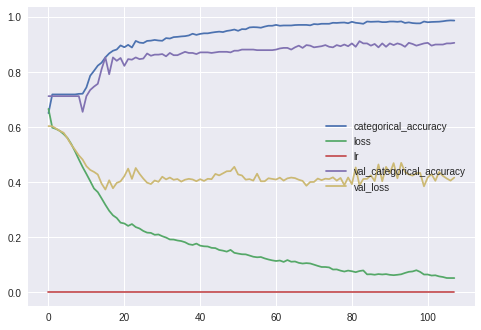

In [269]:
params = []
model = get_model(0.4)
history = model.fit(train_data, y, validation_split=0.2,verbose=1,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=callbacks_list)
score = model.evaluate(train_data, y)
print(score)
history = pd.DataFrame(history.history)
history.plot()

In [270]:

load_model = keras.models.load_model(filepath)
score = load_model.evaluate(test_data,y[test_index])
print('Test best loss:', score[0])
print('Test best accuracy:', score[1])

KeyboardInterrupt: ignored

In [119]:
print("KFlod")
print("Sample",len(X))
print("Score",pd.DataFrame(scores).mean()[1]*100)
print("Std",pd.DataFrame(scores).std()[1]*100)


KFlod
Sample 2452
Score 68.23001632658344
Std 7.638086368022205


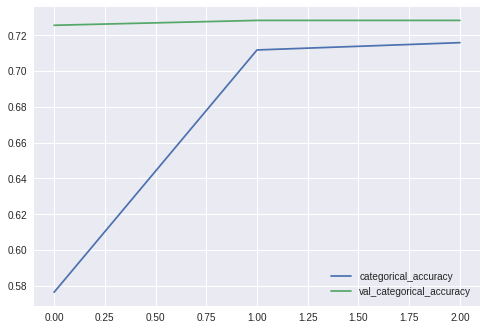

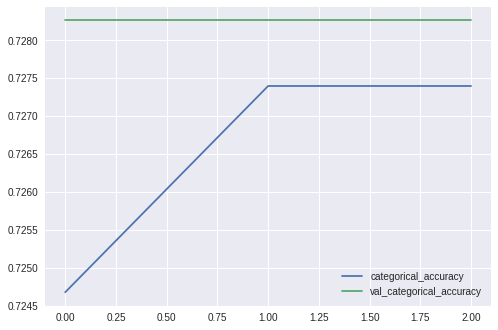

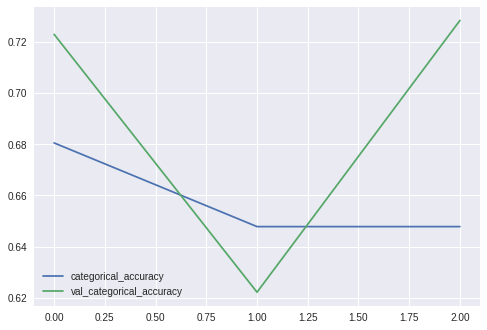

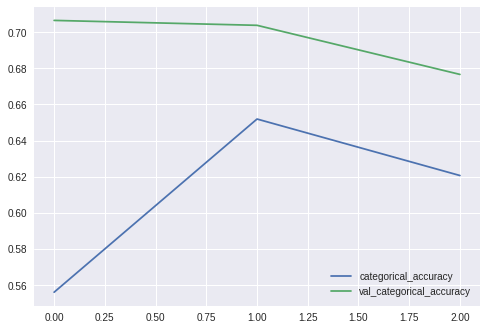

In [120]:
for i in range(len(historys)):
  df = pd.DataFrame(historys[i].history)
#   df.filter(regex=('loss*')).plot()
  df.filter(regex=('accuracy$')).plot()
  
plt.show()
  

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


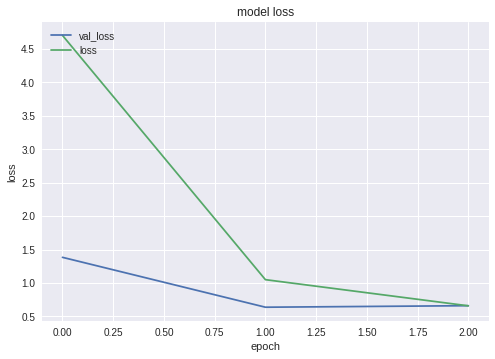

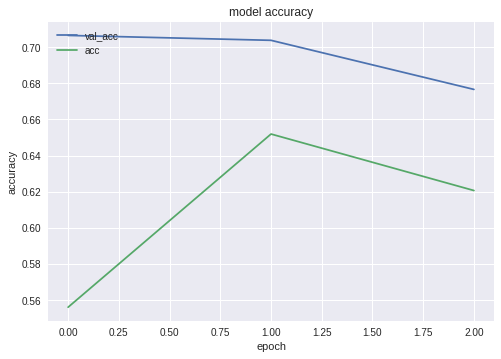

In [121]:

import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_acc', 'acc'], loc='upper left')
plt.show()

In [122]:
len(test_index)

613

In [0]:
raw_df['pred'] = load_model.predict(X).argmax(axis=1)

In [25]:
error_df = raw_df.query("true != pred")
print(len(error_df))
error_df[['label','true','pred','url','text']].to_csv(base_dir+'error.csv',index=False)

50


In [26]:

def df_to_X(raw_df:pd.DataFrame):
  raw_df['edit_text'] = raw_df['text'].apply(lambda x : prepro(x))
  regex = "^(sorry.? (we can.t|this (product|page)))|^(sorry we.re sold out)|^(404|whoops, our bad...|it.s gone|out of stock|sold out|在庫切れ|在庫なし|完売しました|売り切れ|ページが見つかりません.*|この製品はもう入手できない.|ci scusiamo per l'inconveniente.|sorry!|back to our favs)$|(((product|page|item|requested) (is |was )?)(not found|no longer|sold out|out of stock|not available))|(re (sorry|sold out)|(ご購入いただけません)|(404 error))|^(sold out\\s*){3,}|ARTICLE.*EN LIGNE|^so sorry.*|404 page not|Don.t Cry|.*is out of stock.|articolo non disponibile";
  p = re.compile(regex)
  raw_df['flag'] = raw_df['text'].apply(lambda x : 0 if p.match(x) == None else 1)
  raw_df['edit_text'] = raw_df['edit_text'].fillna("")

  save_text_tokenizer(token,base_dir + 'text_token')
  X = token.texts_to_matrix(raw_df['edit_text'].values)
  flag = np.array(raw_df['flag'])
  flag = flag.reshape(len(flag),1)
#   print('flag',flag.shape,'X',X.shape)
  # X = np.concatenate((flag,X),axis=1)

  # X = flag
  # text_len = len(X[0])
  # print(f'text_len:{text_len} samples:{len(X)}')
#   print('word_count',len(token.word_counts))
#   print(token.word_counts)
#   print(token.word_index)
  X = np.array(X)
  return X

def get_split_num(text:str,num:int)->int:
    max_len = int(len(text))
    return int(max_len / num)
  
split = 10
df = pd.DataFrame()
pred_df = pd.DataFrame()
result = []
for i in range(split):
  df['text'] = raw_df['text'].apply(lambda x : x[get_split_num(x,split)*i:get_split_num(x,split)*(i+1)])
  X = df_to_X(df)
  first = load_model.predict(X).argmax(axis=1)
  result.append(first)
result

[array([0, 1, 1, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 1, ..., 1, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0])]

In [64]:
X = np.array(result)
X = X.T
print(X.shape)
X = X.reshape(len(X),split,1)
print(X.shape)
print(X[0:10:],y[0:10])

(2452, 10)
(2452, 10, 1)
[[[0]
  [0]
  [0]
  [1]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]]

 [[1]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[1]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]]] [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [59]:
lstm_model = models.Sequential()
lstm_model.add(layers.LSTM(1,input_shape=(split,1)))
# lstm_model.add(layers.Flatten())
lstm_model.add(layers.Dense(2,activation='relu'))
lstm_model.compile(loss='categorical_crossentropy',optimizer ='adam',metrics=['categorical_accuracy'])
history = lstm_model.fit(X,y,epochs=5,validation_split=0.2,batch_size=10)

Train on 1961 samples, validate on 491 samples
Epoch 1/5
1961/1961 [==============================] - 9s 4ms/step - loss: 4.1425 - categorical_accuracy: 0.7343 - val_loss: 4.0706 - val_categorical_accuracy: 0.7413
Epoch 2/5
1961/1961 [==============================] - 6s 3ms/step - loss: 4.1425 - categorical_accuracy: 0.7343 - val_loss: 4.0706 - val_categorical_accuracy: 0.7413
Epoch 3/5
1961/1961 [==============================] - 6s 3ms/step - loss: 4.1425 - categorical_accuracy: 0.7343 - val_loss: 4.0706 - val_categorical_accuracy: 0.7413
Epoch 4/5
1961/1961 [==============================] - 6s 3ms/step - loss: 4.1425 - categorical_accuracy: 0.7343 - val_loss: 4.0706 - val_categorical_accuracy: 0.7413
Epoch 5/5
1961/1961 [==============================] - 6s 3ms/step - loss: 4.1425 - categorical_accuracy: 0.7343 - val_loss: 4.0706 - val_categorical_accuracy: 0.7413


In [0]:
pred = lstm_model.predict(X)

In [73]:
pred.argmax(axis=1)[0:10]

array([1, 1, 1, 0, 1, 0, 1, 1, 0, 0])

In [74]:
np.array(y).argmax(axis=1)[0:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])